In [ ]:
# -----------------------------------------------------------------------------
# ---------------------------------------------------------------------------

import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Expanded PESTEL dictionary
PESTEL_KEYWORDS = {
    'Political': ['policy', 'government', 'regulation', 'election', 'diplomacy', 'politics',
                  'parliament', 'law', 'governance', 'public', 'reform', 'voting', 'ethics'],
    'Economic': ['market', 'finance', 'trade', 'business', 'investment', 'growth', 'inflation', 'management',
                 'recession', 'tax', 'industry', 'corporation', 'employment', 'GDP', 'economy'],
    'Social': ['society', 'culture', 'education', 'health', 'community', 'demographics',
               'inequality', 'media', 'family', 'religion', 'values', 'social', 'behavior'],
    'Technological': ['technology', 'innovation', 'AI', 'digital', 'automation', 'robotics',
                      'software', 'hardware', 'internet', 'cybersecurity', 'data', 'platform', 'network'],
    'Environmental': ['environment', 'climate', 'sustainability', 'pollution', 'recycling', 'SDG',
                      'conservation', 'biodiversity', 'carbon', 'global warming', 'renewable', 'nature'],
    'Legal': ['law', 'regulation', 'compliance', 'litigation', 'intellectual property',
              'contracts', 'dispute', 'human rights', 'legal', 'taxation']
}

class DataReader:
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def read_data(self):
        dfs = []
        for file_path in self.file_paths:
            try:
                df = pd.read_excel(file_path)
                dfs.append(df)
            except FileNotFoundError:
                print(f"Warning: File not found - {file_path}")
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        if dfs:
            return pd.concat(dfs, ignore_index=True)
        else:
            return pd.DataFrame()

class TextDocumentCleaner:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, df):
        df['cleaned_documents'] = df['documents'].astype(str).apply(self.clean)
        return df

    def clean(self, text):
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip().lower()
        return text

class TopicModel:
    def __init__(self, num_topics=6, max_features=3000):
        self.num_topics = num_topics
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features, max_df=0.9, min_df=5)
        self.lda = LatentDirichletAllocation(n_components=num_topics, max_iter=100, learning_method='batch', random_state=42)
        self.terms = None

    def fit(self, documents):
        X = self.vectorizer.fit_transform(documents)
        self.lda.fit(X)
        self.terms = self.vectorizer.get_feature_names_out()
        return X

    def transform(self, documents):
        return self.lda.transform(self.vectorizer.transform(documents))

    def get_topics(self, top_n=10):
        return [[self.terms[i] for i in topic.argsort()[:-top_n-1:-1]] for topic in self.lda.components_]

class PESTELMapper:
    def __init__(self, pestel_keywords):
        self.pestel_keywords = pestel_keywords

    def fit(self, X, y=None):
        return self

    def transform(self, topics):
        return [[dim for dim, keywords in self.pestel_keywords.items() if set(terms) & set(keywords)]
                or ['Unclassified'] for terms in topics]

class TopicEvolutionAnalyzer:
    def __init__(self, topic_model, topic_mapper):
        self.topic_model = topic_model
        self.topic_mapper = topic_mapper

    def analyze(self, df):
        # Extract topics and map to PESTEL
        topics = self.topic_model.get_topics()
        topic_mapping = self.topic_mapper.transform(topics)

        print("\n=== Identified Topics ===")
        for idx, terms in enumerate(topics):
            print(f"Topic {idx + 1}: {' '.join(terms)} --> {', '.join(topic_mapping[idx])}")

        # Track and plot topic evolution
        self.track_evolution(df)

    def track_evolution(self, df):
        df['Year'] = df['Year'].astype(int)
        years = sorted(df['Year'].unique())
        evolution_df = pd.DataFrame({
            year: self.topic_model.transform(df.loc[df['Year'] == year, 'cleaned_documents']).mean(axis=0)
            for year in years
        }, index=[f'Topic {i+1}' for i in range(self.topic_model.num_topics)]).T
        evolution_df.plot(figsize=(12, 8), marker='o', title="Evolution of Topics Over Time")
        plt.xlabel('Year')
        plt.ylabel('Average Contribution')
        plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

In [ ]:
# Example usage
f1 = "https://github.com/masterfloss/blockchainbanking/raw/refs/heads/main/BlockchainBank1.xlsx"
#f2 = "https://github.com/masterfloss/bibliography/raw/refs/heads/main/biblio_part_2.xlsx"
#f3 = "https://github.com/masterfloss/bibliography/raw/refs/heads/main/biblio_part_3.xlsx"

file_paths = [f1]
data_reader = DataReader(file_paths)

df = data_reader.read_data()

In [ ]:
df

,Unnamed: 0,Year,Title,Abstract,Author Keywords,Index Keywords
0,0,2024,Argument by False Analogy: The Mistaken Classi...,This paper documents inconsistent terminologie...,bank payments; bank reserves; blockchain; CBDC...,NaN
1,1,2025,Central Bank Digital Currencies: Financial Sta...,"Digitalization of the global economy, catalyse...",CBDCs; central bank; central bank digital curr...,NaN
2,2,2025,THE IMPACT OF SECURITY AND PRIVACY PERCEPTIONS...,This study examines how perceived security and...,applications; cryptocurrency; privacy; ratings...,NaN
3,3,2025,Generative Artificial Intelligence in Finance:...,This comprehensive volume delves deep into the...,NaN,NaN
4,4,2025,The policy endorsement of central bank digital...,The digital advancement is moving at a faster ...,bibliometric analysis; blockchain; CBDC; centr...,NaN
...,...,...,...,...,...,...
1303,1303,2016,Understanding modern banking ledgers through b...,In this chapter we provide an overview of the ...,Banking ledgers; Blockchain; Data integrity; D...,NaN
1304,1304,2016,Leveraging bitcoin blockchain technology to mo...,The states of the United States operate parall...,Bitcoin; Blockchain; Distributed databases; Go...,Codes (symbols); Database systems; Digital sto...
1305,1305,2016,Blockchains and the boundaries of self-organiz...,This chapter uses economic theory to explore t...,Austrian economics; Bitcoin; Blockchain; Catal...,NaN
1306,1306,2016,Introduction,New technologies are dramatically transforming...,Blockchain; Crowdfunding; Distributed ledger t...,NaN


In [ ]:
#df['documents'] = df[['Title','Abstract', 'Author Keywords']].fillna('').agg(' '.join, axis=1)
df['documents'] = df[[ 'Author Keywords','Title','Index Keywords']].fillna('').agg(' '.join, axis=1)


cleaner = TextDocumentCleaner()
df = cleaner.transform(df)

In [ ]:
df['cleaned_documents']

,cleaned_documents
0,bank payments bank reserves blockchain cbdc ce...
1,cbdcs central bank central bank digital curren...
2,applications cryptocurrency privacy ratings re...
3,generative artificial intelligence in finance ...
4,bibliometric analysis blockchain cbdc central ...
...,...
1303,banking ledgers blockchain data integrity data...
1304,bitcoin blockchain distributed databases gover...
1305,austrian economics bitcoin blockchain catallax...
1306,blockchain crowdfunding distributed ledger tec...


In [ ]:
topic_model = TopicModel(num_topics=4, max_features=1000)
topic_model.fit(df['cleaned_documents'])
topics = topic_model.get_topics()

topic_mapper = PESTELMapper(PESTEL_KEYWORDS)

analyzer = TopicEvolutionAnalyzer(topic_model, topic_mapper)
topic_mapping = topic_mapper.transform(topics)


=== Identified Topics ===
Topic 1: supply bank digital currency central blockchain chain cryptocurrency cryptocurrencies money --> Technological
Topic 2: blockchain security smart data systems decentralized privacy distributed contract network --> Technological
Topic 3: financial banking fintech blockchain technology digital sector finance industry islamic --> Economic, Technological
Topic 4: international conference learning machine th business detection fraud insurance investment --> Economic


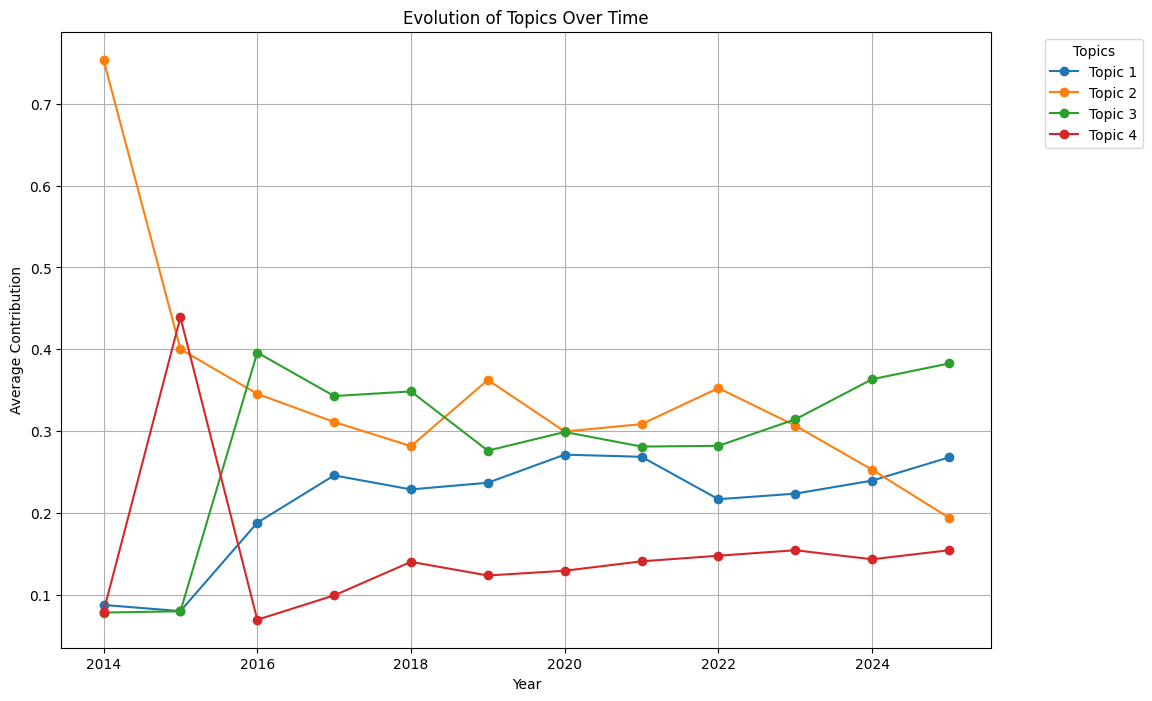

In [ ]:


#topic_mapping = topic_mapper.transform(topics)
#analyzer = TopicEvolutionAnalyzer(topic_model, topic_mapper)
analyzer.analyze(df)